# Mandelbrot set visualization

A vanilla python/numpy implementation of a Mandelbrot set visualizer.

The code has been liberally inspired by [this implementation from Jean-François Puget](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en).

Follow the [above link](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en) also for more information on the Maldebrot set and the colorization procedure.

In [1]:
import warnings
import numpy as np
from matplotlib import colors, patches, pyplot as plot

%matplotlib inline

Let's define a procedure to sample a region of the complex plane:

In [2]:
pois = {  # points of interest
    'full': (-2.0, 0.5, -1.25, 1.25),
    'valley': (-0.8, -0.7, 0.0, 0.1),
    'sea_horses': (-0.755, -0.745, 0.06, 0.07),
    'sea_horse': (-0.75, -0.747, 0.063, 0.066),
    'sea_horse_tail': (-0.749, -0.748, 0.065, 0.066),
    'black_dot': (-0.74877,-0.74872,0.06505,0.06510)}


def complex_grid(xmin, xmax, ymin, ymax, res=1024):
    xx = np.linspace(xmin, xmax, num=res)
    yy = np.linspace(ymin, ymax, num=res)
    x, y = np.meshgrid(xx, yy)
    return x + 1j * y

Here's the most crude, synthetic and straighforward implementation:

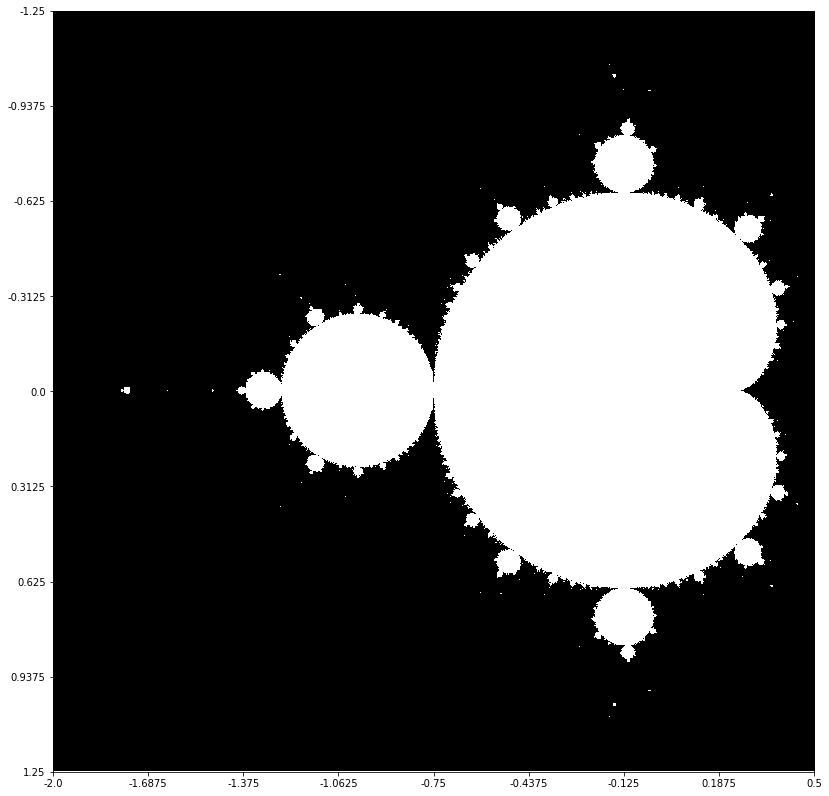

In [3]:
def mandelbrot_boolean(coords, max_iterations=256):

    values = coords.copy()
    for _ in range(max_iterations):        
        values = values ** 2 + coords
    return (abs(values) < 2).astype(np.float)


def show(mandelbrot_function, name):
    
    plot.figure(figsize=(14, 14))
    image = mandelbrot_function(complex_grid(*pois[name]))
    plot.imshow(image, cmap='gnuplot2', norm=colors.PowerNorm(0.3))
    plot.xticks(np.linspace(0, image.shape[0], num=9), np.round(np.linspace(*pois[name][:2], num=9), 4))
    plot.yticks(np.linspace(0, image.shape[1], num=9), np.round(np.linspace(*pois[name][2:], num=9), 4))
    plot.show()    


warnings.filterwarnings('ignore')  # ignore warnings about overflows
show(mandelbrot_boolean, 'full')
warnings.filterwarnings('default')

Let's keep track and visualize the number of iterations required to diverge:

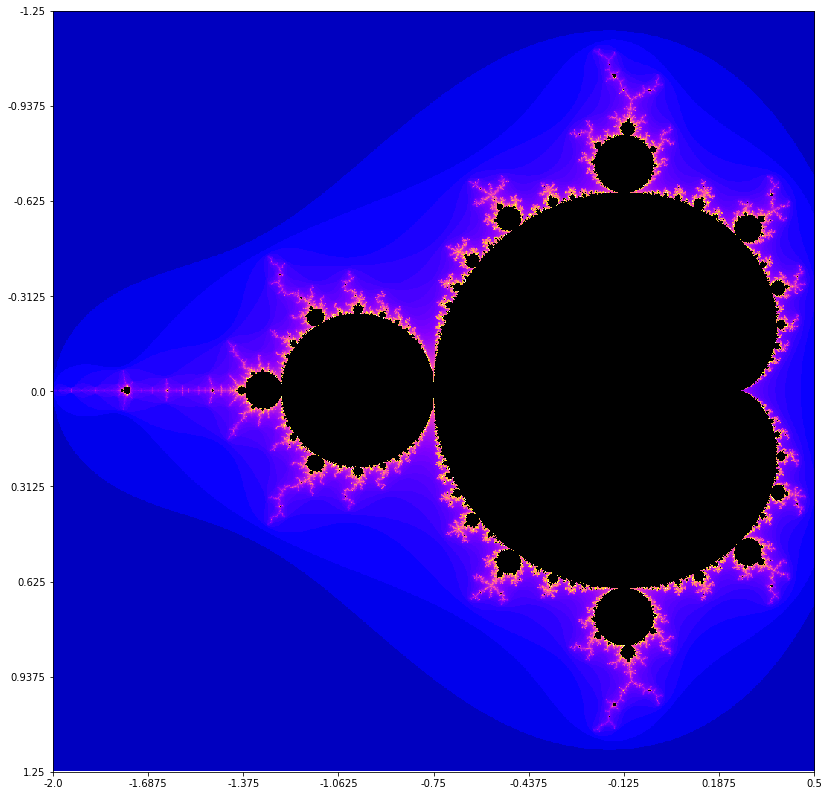

In [4]:
def mandelbrot_discrete(coords, max_iterations=256):

    values = coords.copy()
    iteration_count = np.zeros_like(values, np.float)
    for iteration in range(max_iterations):

        nya = iteration_count == 0  # not yet assigned
        values[nya] = values[nya] ** 2 + coords[nya]
        
        abs_values = np.abs(values)
        jd = np.logical_and(nya, abs_values > 2)  # just diverged        
        iteration_count[jd] = iteration

    return iteration_count


show(mandelbrot_discrete, 'full')

To avoid banding effects, we take into account not just the iteration number but the value as well.

See [this implementation by Jean-François Puget](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en) for an explanation of the technique.

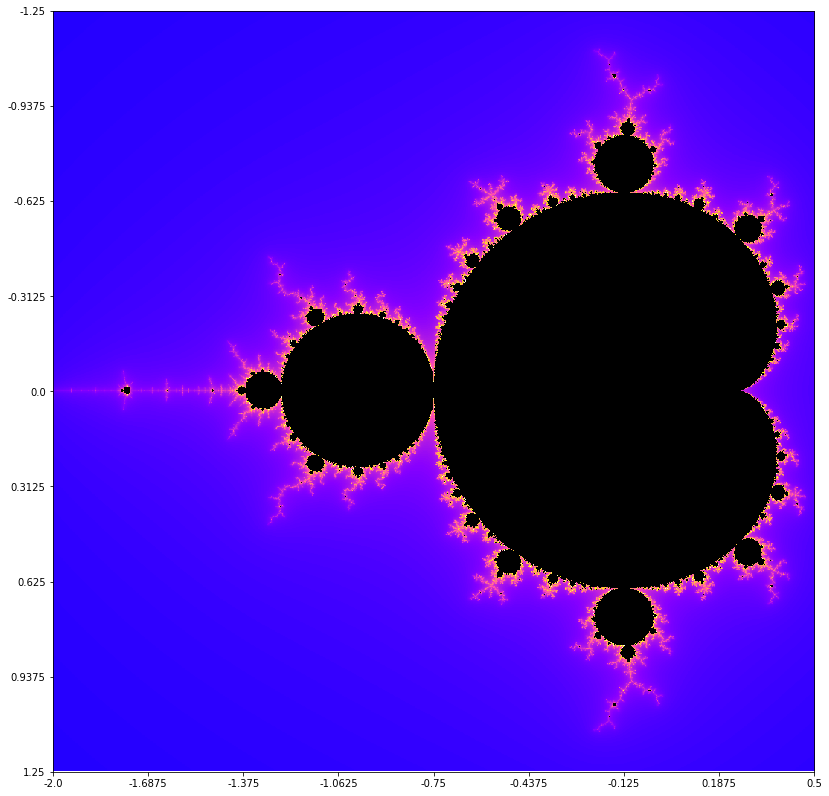

In [5]:
def mandelbrot_continuous(coords, max_iterations=256):

    horizon = 2.0 ** 40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    
    values = coords.copy()
    iteration_count = np.zeros_like(values, np.float)
    for iteration in range(max_iterations):
        
        nya = iteration_count == 0  # not yet assigned
        values[nya] = values[nya] ** 2 + coords[nya]
        
        abs_values = np.abs(values)
        jd = np.logical_and(nya, abs_values > horizon)  # just diverged        
        iteration_count[jd] = iteration - np.log(np.log(abs_values[jd])) / np.log(2) + log_horizon        
    
    return iteration_count


show(mandelbrot_continuous, 'full')

More pretty pictures:

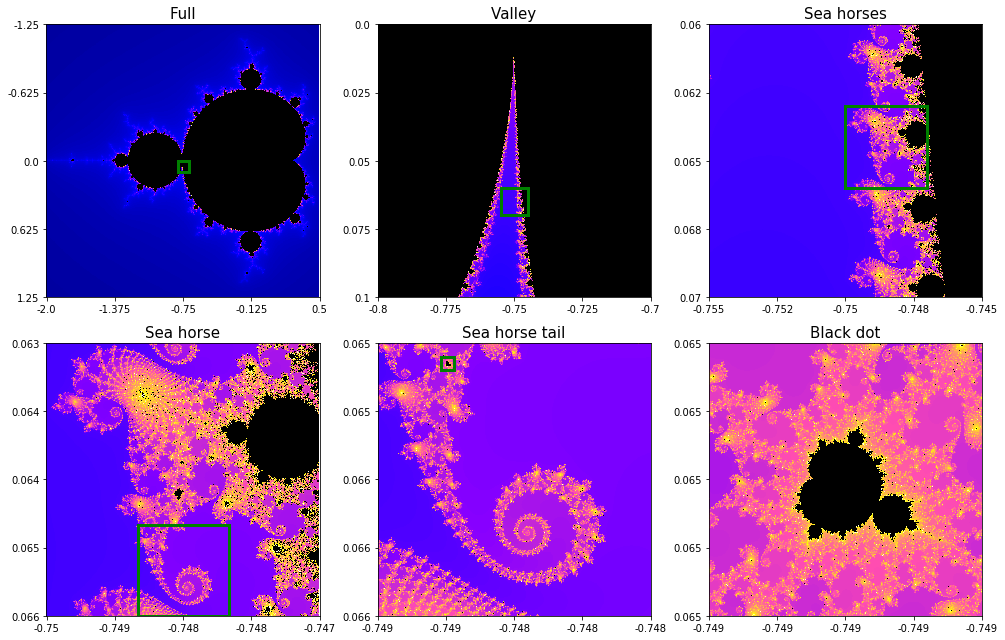

In [6]:
fig = plot.figure(figsize=(14, 9))
names = ('full', 'valley', 'sea_horses', 'sea_horse', 'sea_horse_tail', 'black_dot')
for index, (name, next_name) in enumerate(zip(names, names[1:] + (None, ))):
    
    ax = plot.subplot(231 + index)
    image = mandelbrot_continuous(complex_grid(*pois[name], res=512), 2048)
    ax.imshow(image, cmap='gnuplot2', norm=colors.PowerNorm(0.3))
    
    plot.xticks(np.linspace(0, image.shape[0], num=5), np.round(np.linspace(*pois[name][:2], num=5), 3))
    plot.yticks(np.linspace(0, image.shape[1], num=5), np.round(np.linspace(*pois[name][2:], num=5), 3))
    plot.title(name.replace('_', ' ').capitalize(), fontsize=15)
    
    if next_name is not None:
        ox, xmax, oy, ymax = pois[name]
        w, h = xmax - ox, ymax - oy
        xmin, xmax, ymin, ymax = pois[next_name]
        x0, y0 = (xmin - ox) / w * image.shape[0], (ymin - oy) / h  * image.shape[1]
        x1, y1 = (xmax - ox) / w * image.shape[0], (ymax - oy) / h  * image.shape[1]        
        ax.add_patch(patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor='g', linewidth=3, facecolor='none'))
    
plot.tight_layout()
plot.show()